# TM10007 Assignment - GIST & non-GIST
Lidewij Hollestelle, Lisanne de Bruin, Lucas Piret and Amber van Teijlingen 

Group 7, GIST and non-GIST

## Load and analyse data

The number of samples: 246
The number of columns: 494
The number of features that are not normally distributed: 443


c:\Users\lisan\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


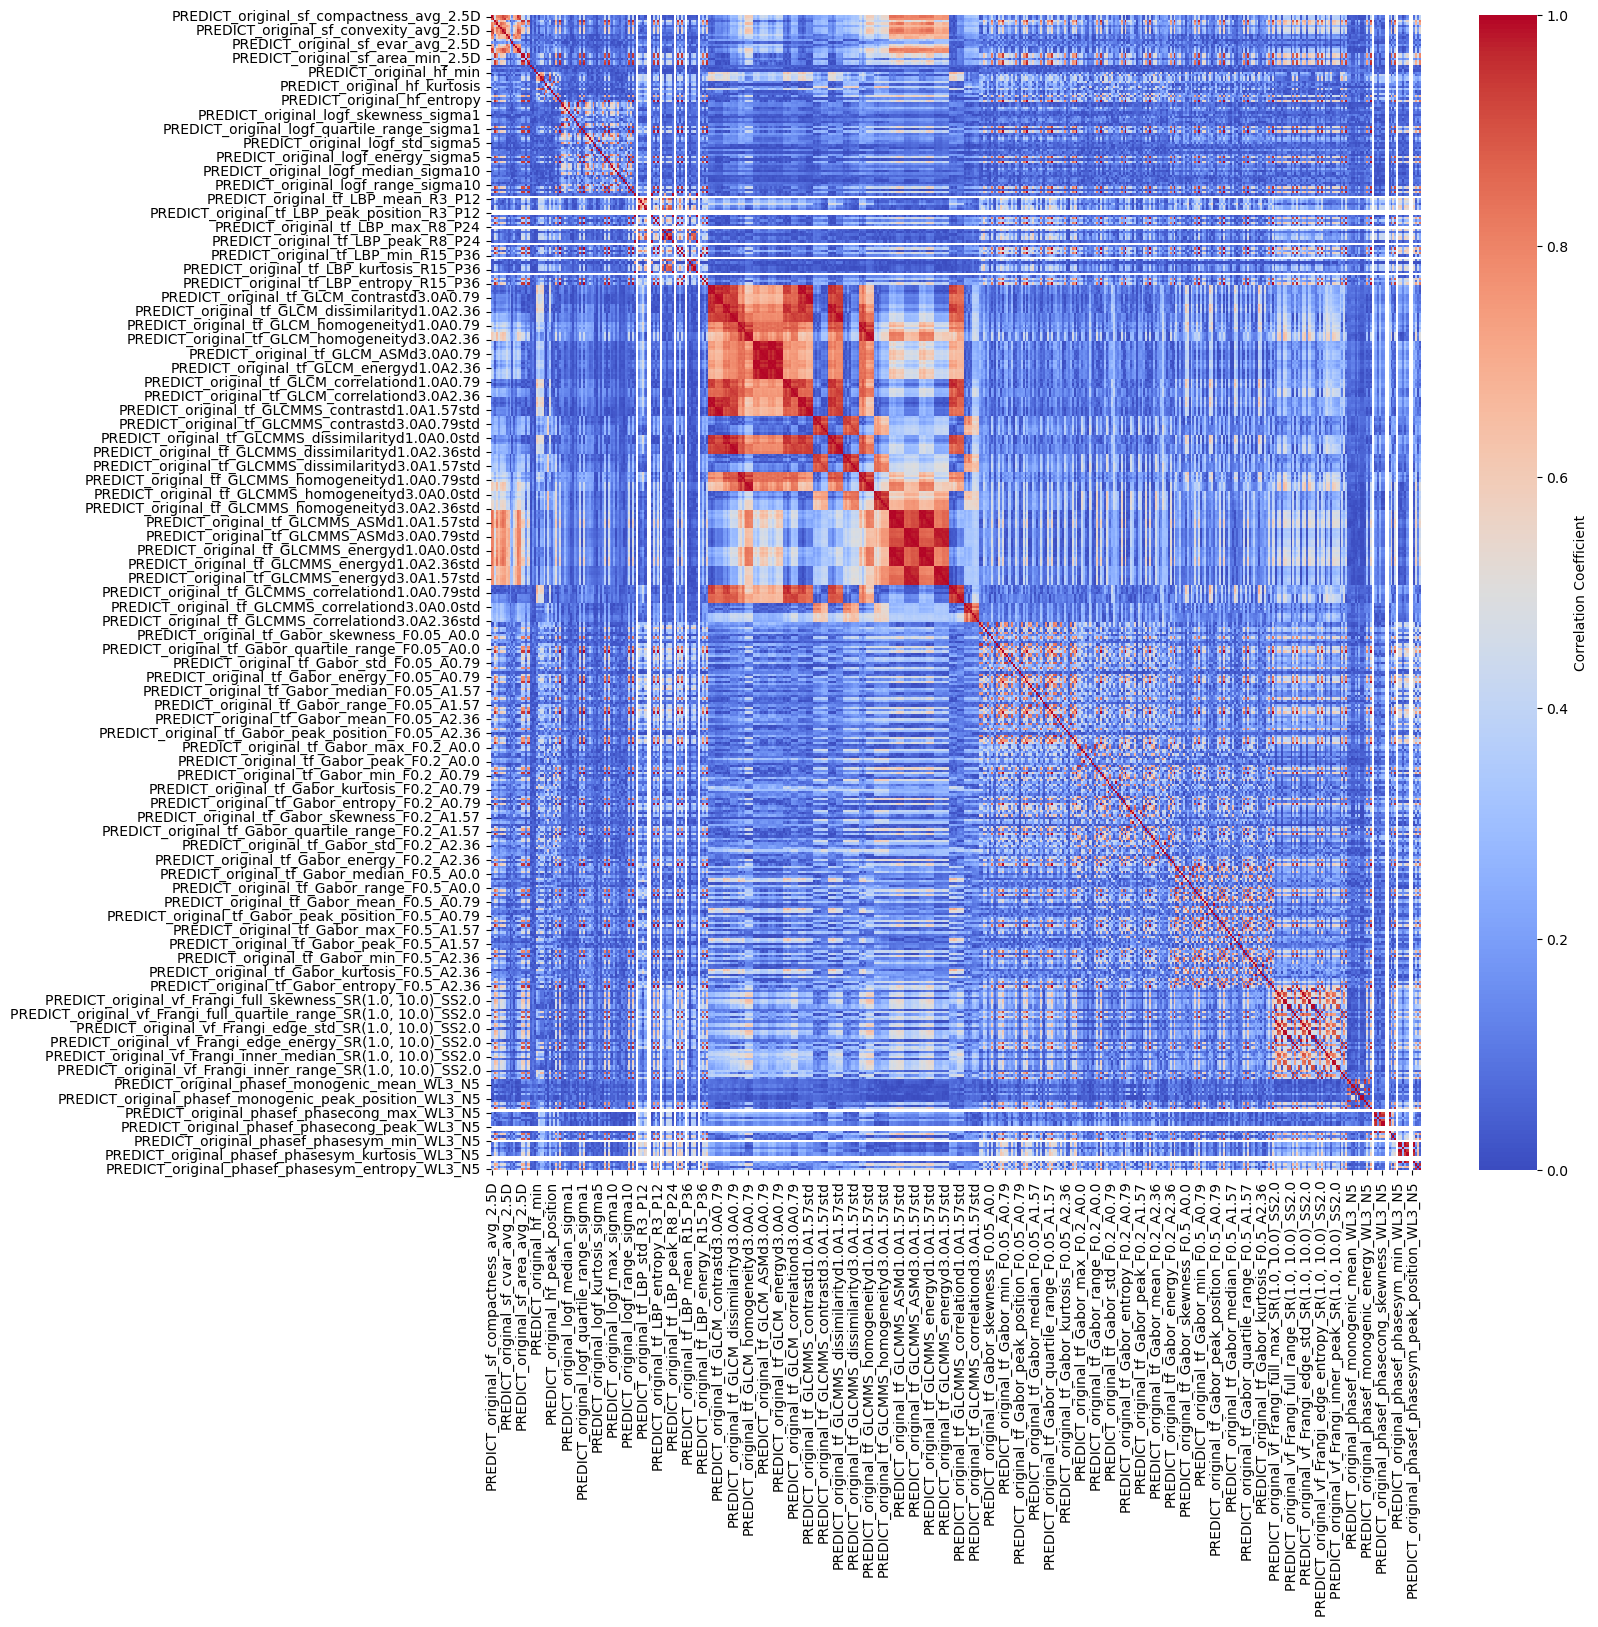

In [28]:
"""
This cell performs the following tasks:
- Imports necessary libraries and sets a random state for reproducibility.
- Loads the dataset using the `load_data` function and separates it into features (`values`) and labels (`labels`).
- Converts categorical labels ('GIST' and 'non-GIST') into numeric values (1 and 0).
- Performs a Shapiro-Wilk test to count the number of features that are not normally distributed.
- Generates a heatmap to visualize the correlation matrix of the features using Spearman's correlation.
"""

# Import libraries
from load_data import load_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro

# Initialize random state for reproducibility
rand_state = 10007

# Load the dataset and print some information
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Seperate the labels from the values
labels = data['label']
values = data.drop(columns=['label'])

# Convert 'GIST' and 'non-GIST' to numeric values
labels = labels.map({'GIST': 1, 'non-GIST': 0})

# Perform Shapiro-Wilk test for normality on each feature
# and count the number of features that are not normally distributed
counter = 0
for feature in values.columns:
    stat, p_value = shapiro(values[feature])
    if p_value < 0.05:
        counter += 1
print(f'The number of features that are not normally distributed: {counter}')

# Heatmap for the entire correlation matrix
correlation_matrix = values.corr(method='spearman').abs()
plt.figure(figsize=(15, 15)) 
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()

## Feature selection and dimension reduction

In [29]:
"""
This cell defines two functions for preprocessing and feature selection:

1. preprocess_train_test(training_values, test_values):
    - In case of missing values, replaces them with the mean of the training data.
    - Standardizes the training and testing data using RobustScaler.
    - Removes features with low variance using VarianceThreshold.

2. statistical_selection(values, labels):
    - Fits a logistic regression model for each feature to compute its p-value.
    - Removes highly correlated features based on Spearman's correlation and p-values.
    - Returns the dataset with selected features.
"""

# Import libraries
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from statsmodels import api as sm

def preprocess_train_test(training_values, test_values):
    """
    Preprocesses the training and testing datasets by handling missing values, standardizing the data, 
    and removing features with low variance.

    Args:
        training_values (pd.DataFrame): The training dataset with features.
        test_values (pd.DataFrame): The testing dataset with features.

    Returns:
        training_values (pd.DataFrame), test_values (pd.DataFrame): The preprocessed training and testing datasets.
    """

    # First we remove NaNs by averaging
    training_values = training_values.fillna(training_values.mean())
    test_values = test_values.fillna(training_values.mean())

    # Standardize the training & testing data separately and turn them into DataFrames
    scaler = RobustScaler()
    scaled_training_values = scaler.fit_transform(training_values)
    training_values = pd.DataFrame(scaled_training_values, columns=training_values.columns, index=training_values.index)

    scaled_test_values = scaler.transform(test_values)
    test_values = pd.DataFrame(scaled_test_values, columns=test_values.columns, index=test_values.index)

    # Remove features with low variance and turn them into DataFrames
    selector = VarianceThreshold(threshold=0.3) 

    training_low_var = selector.fit_transform(training_values)
    training_values = pd.DataFrame(training_low_var, columns=training_values.columns[selector.get_support()], index=training_values.index)

    test_low_var = selector.transform(test_values)
    test_values = pd.DataFrame(test_low_var, columns=test_values.columns[selector.get_support()], index=test_values.index)

    return training_values, test_values

def statistical_selection(values, labels, k=None):
    """
    Remove highly correlated features.
    Keeps only the features with the lowest p-values from univariate logistic regression.
    If k is not None, selects the top k features based on the lowest p-value.

    Args:
        values (pd.DataFrame): The dataset containing features.
        labels (pd.Series): The target labels corresponding to the dataset.
        k (int, optional): The number of top features to select based on p-values. If None, all features are retained.

    Returns:
        values (pd.DataFrame), labels (pd.Index): The dataset with selected features and the names of the selected features.
    """

    # Now we perform univariate logistic regression to get the correlation of the features with the label
    p_values = {}

    for column in values.columns:
        logit_model = sm.Logit(labels, values[column])
        result = logit_model.fit(disp = False)

        p_values[column] = result.pvalues[column]

    # Remove highly correlated values
    correlation_matrix = values.corr(method = 'spearman').abs()

    features_to_remove = []

    # Loop through all combinations of features
    for feature1 in correlation_matrix.columns:
        for feature2 in correlation_matrix.columns:
            # If they are not the same feature and not already marked for removal
            if feature1 != feature2 and feature1 not in features_to_remove and feature2 not in features_to_remove:
                # Check if the features are highly correlated
                if correlation_matrix[feature1][feature2] > 0.90:
                    # Remove the feature with the higher p-value
                    if p_values[feature1] > p_values[feature2]:
                        features_to_remove.append(feature1)
                    else:
                        features_to_remove.append(feature2)

    # Remove the features that are marked for removal
    values = values.drop(columns=features_to_remove)
    
    # If k was specified, select the top k features
    if k:
        # Remove the features from p_values as well
        for feature in features_to_remove:
            del p_values[feature]

        # Select the top k features with the lowest p-values
        sorted_features = sorted(p_values, key=p_values.get)[:k]
        values = values[sorted_features]

    return values, values.columns

"""
def perform_PCA(values):
    pca = decomposition.PCA(n_components=30)
    pca.fit(values)
    training_values_pca = pca.transform(values)

    # Now, create the DataFrame with new column names (for the PCA components)
    training_values = pd.DataFrame(training_values_pca, 
                                columns=[f'PC{i+1}' for i in range(training_values_pca.shape[1])], 
                                index=values.index)
    return training_values
"""

"\ndef perform_PCA(values):\n    pca = decomposition.PCA(n_components=30)\n    pca.fit(values)\n    training_values_pca = pca.transform(values)\n\n    # Now, create the DataFrame with new column names (for the PCA components)\n    training_values = pd.DataFrame(training_values_pca, \n                                columns=[f'PC{i+1}' for i in range(training_values_pca.shape[1])], \n                                index=values.index)\n    return training_values\n"

## Make learning curve

In [30]:
from sklearn.model_selection import learning_curve
import numpy as np

# Make learning
def plot_learning_curve(model, training_data, training_labels, cv, model_name):    
    train_sizes, train_scores, validation_scores = learning_curve(
        model, training_data, training_labels, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation of the scores
    train_mean = train_scores.mean(axis=1)
    validation_mean = validation_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    validation_std = validation_scores.std(axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training score", color="r")
    plt.plot(train_sizes, validation_mean, label="Cross-validation score", color="g")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.2)

    # Adding labels and title
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.ylim(0.3, 1.01)
    plt.title(f"Learning Curve for {model_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

## Make ROC curve

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_best_model_roc(probs, test_labels, model_name, fold):
    
    """
    Plots the ROC curve for the best model on a given fold.

    Parameters:
        probs (list): List of predicted probabilities for the positive class.
        test_labels (list): True labels for the test set.
        model_name (str): Name of the model for the title. 
        fold_number (int): Fold number.
    """
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(test_labels, probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f'ROC Curve - {model_name} (Fold {fold})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)

def logistic_regression(training_values, training_labels):
    elastic_net = LogisticRegressionCV(
        solver='saga',
        penalty='elasticnet',
        Cs=[1, 10, 100],
        l1_ratios=[0.8],
        max_iter=10000,
        cv=cv,
        n_jobs=-1,
        random_state = rand_state
    )

    elastic_net.fit(training_values, training_labels)

    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=elastic_net,
        X=training_values,
        y=training_labels,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    #plot_learning_curve(elastic_net, training_values, training_labels, cv, 'Logistic regression')

    selected_features = np.where(elastic_net.coef_ != 0)[0]

    print(f"{len(selected_features)} features selected out of {len(training_values.columns)}")

    training_values = training_values.iloc[:, selected_features]

    return elastic_net, cv_scores, training_values



## Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold

def train_random_forest(training_values, training_labels):
    # Initialize the Random Forest Classifier
    param_grid = {
        'n_estimators': randint(1, 100),
        'max_depth': randint(1, 30),
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': randint(1, 10)
        }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
    
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=rand_state), param_distributions=param_grid, n_iter=100, cv=cv, n_jobs=-1, random_state=rand_state)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_

    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=best_model,
        X=training_values,
        y=training_labels,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    #plot_learning_curve(best_model, training_values, training_labels, cv, 'Random Forest')

    return best_model, cv_scores

    """
    feature_importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': training_values.columns,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    all_scores = []
    for i in range(1, 493):
        top_features = feature_importance_df.head(i)['Feature'].values

        data_selected = training_values[top_features]
        labels_selected = training_labels

        final_model = best_model.fit(data_selected, labels_selected)
        cv_scores = cross_val_score(final_model, data_selected, labels_selected, cv=5)
        all_scores.append(cv_scores.mean())

    # Plot the cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 493), all_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Top Features')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Random Forest Number of Included Top Features')
    plt.grid(True)
    plt.show()
    """

 

## KNN-classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

def KNN(training_values, training_labels):
    param_grid = {
    'n_neighbors': list(range(1, 26)),
    'weights': ['uniform', 'distance']
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)

    random_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, n_jobs=-1)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_

    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=best_model,
        X=training_values,
        y=training_labels,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )

    #plot_learning_curve(best_model, training_values, training_labels, cv, 'KNN')

    return best_model, cv_scores


## SVM

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

def SVM(training_values, training_labels):
    param_grid = {
        'C': [0.1, 0.5, 1, 5], 
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 0.01, 0.1, 1],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
    
    random_search = GridSearchCV(SVC(probability=True), param_grid, cv=cv, n_jobs=-1)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_

    scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
    }

    cv_scores = cross_validate(
        estimator=best_model,
        X=training_values,
        y=training_labels,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )

    #plot_learning_curve(best_model, training_values, training_labels, cv, 'SVM')

    return best_model, cv_scores

## Try the different classifiers for 5 different folds


=== Fold 0 ===
(196, 462)
Start
9 features selected out of 10
Fold 0 - Logistic Regression Score: 0.6126923076923076


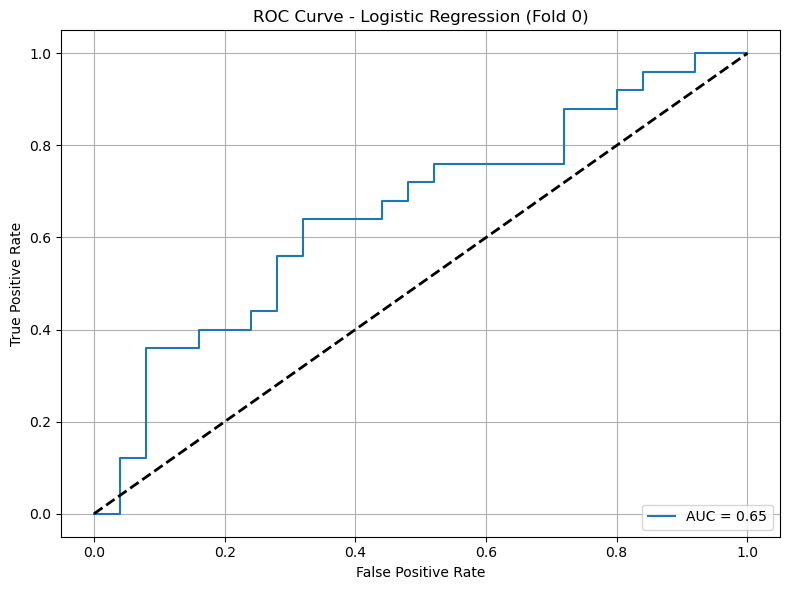

Best hyperparameters: {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 9, 'n_estimators': 67}
Fold 0 - Random Forest Score: 0.6683333333333333


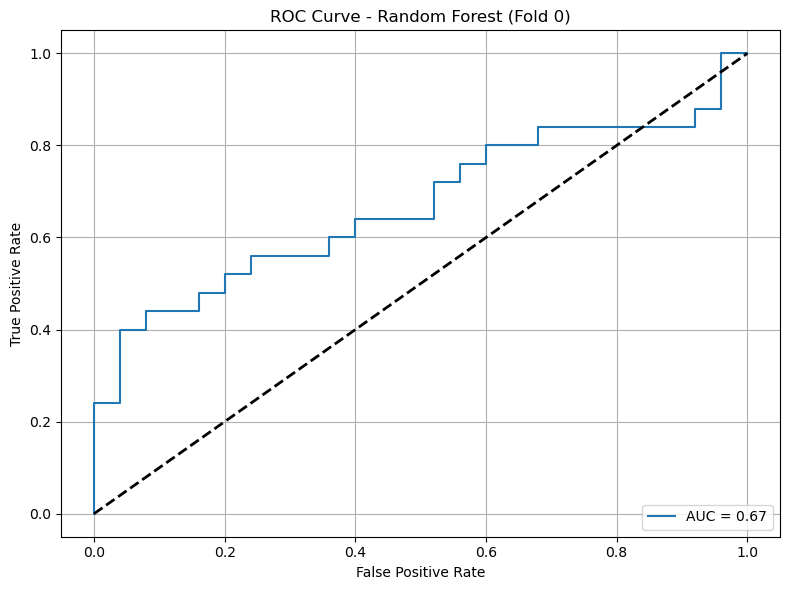

Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance'}
Fold 0 - KNN Score: 0.6328205128205128


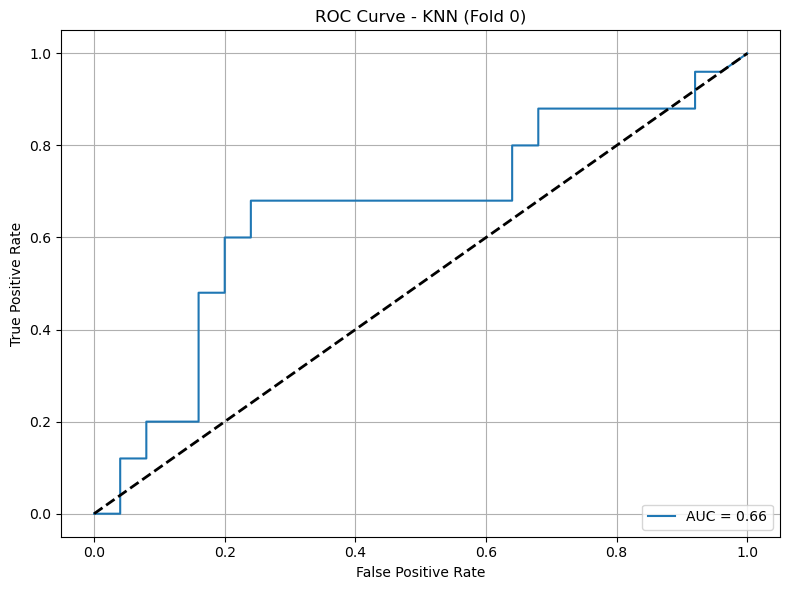

Best hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Fold 0 - SVM Score: 0.6533333333333333


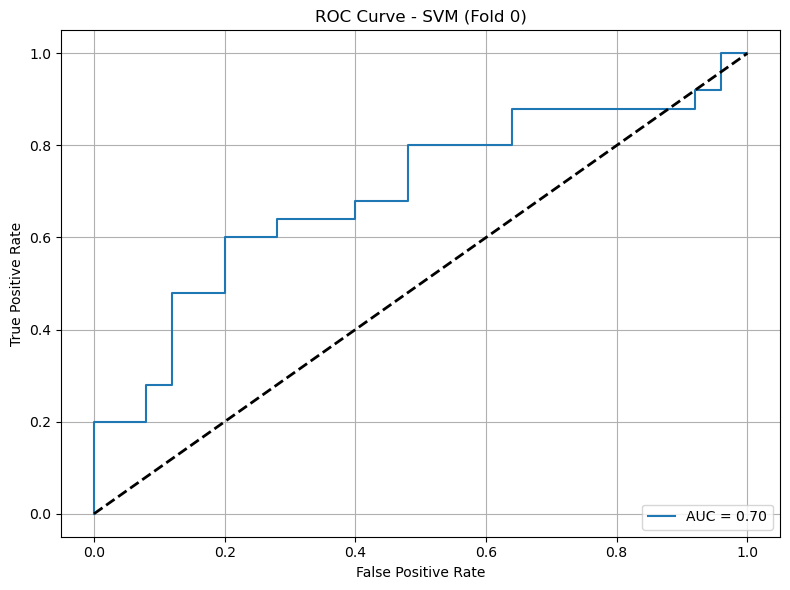


=== Fold 1 ===
(197, 461)
Start
7 features selected out of 10
Fold 1 - Logistic Regression Score: 0.6753846153846153


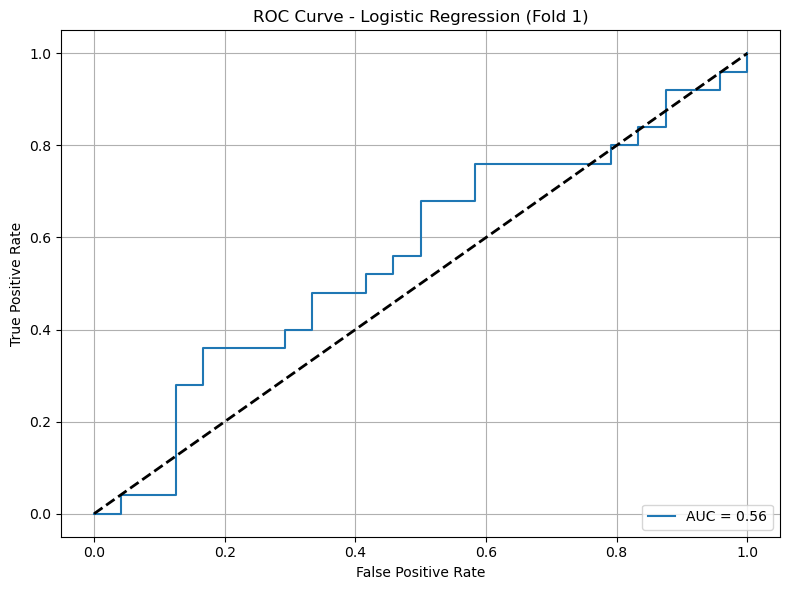

Best hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 46}
Fold 1 - Random Forest Score: 0.706025641025641


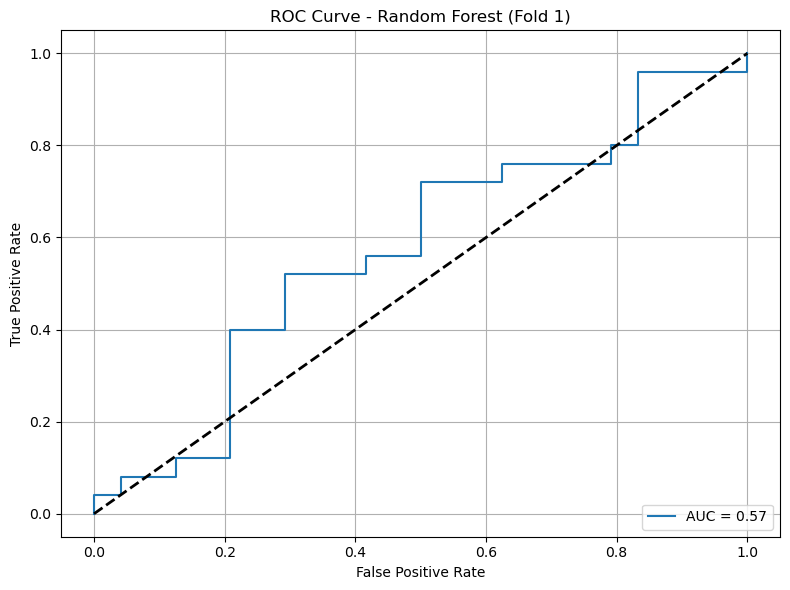

Best hyperparameters: {'n_neighbors': 14, 'weights': 'uniform'}
Fold 1 - KNN Score: 0.6701282051282051


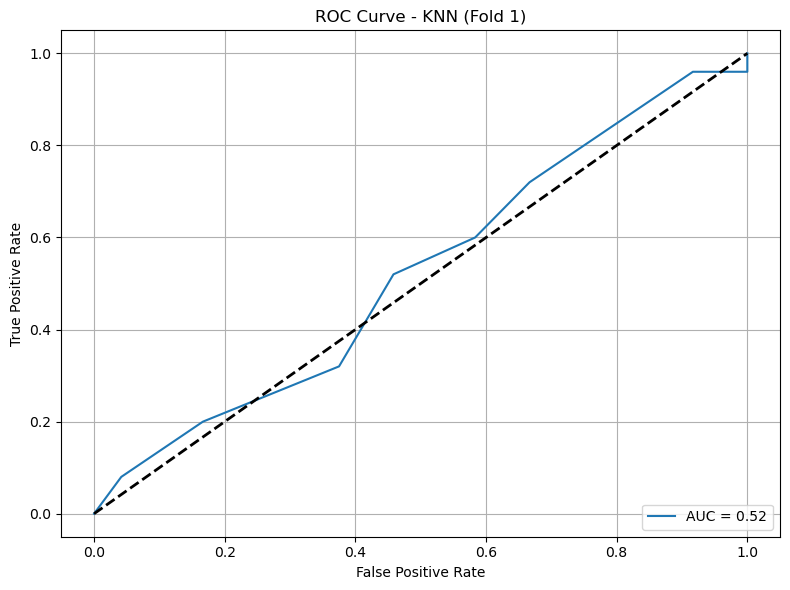

Best hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 1 - SVM Score: 0.6757692307692308


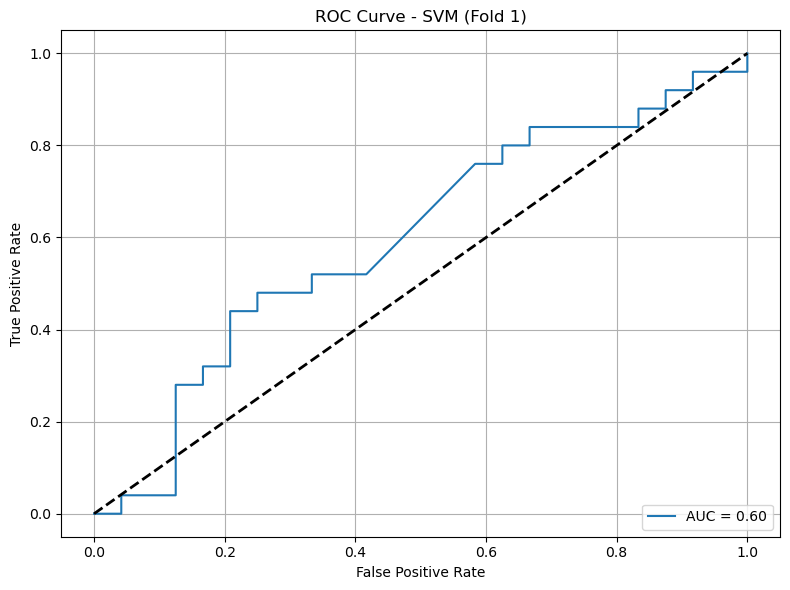


=== Fold 2 ===
(197, 460)
Start
7 features selected out of 10
Fold 2 - Logistic Regression Score: 0.6348717948717949


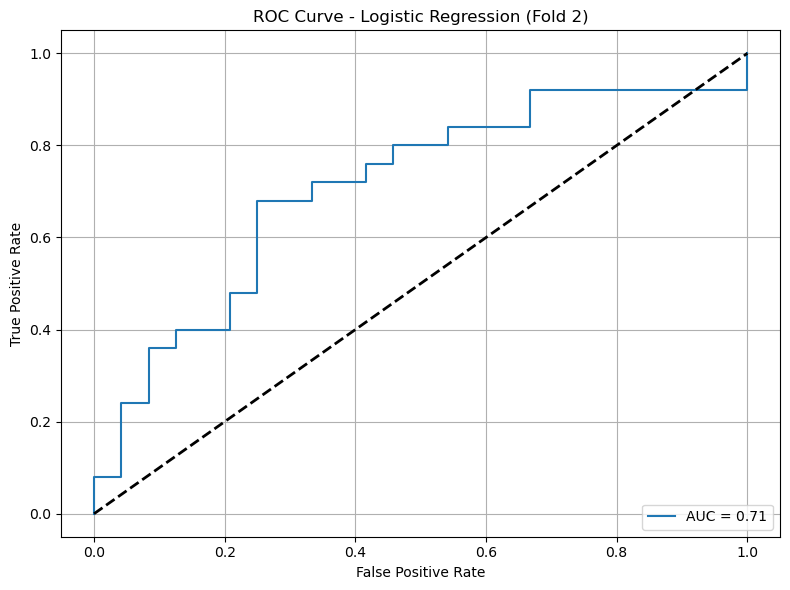

Best hyperparameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 56}
Fold 2 - Random Forest Score: 0.6957692307692308


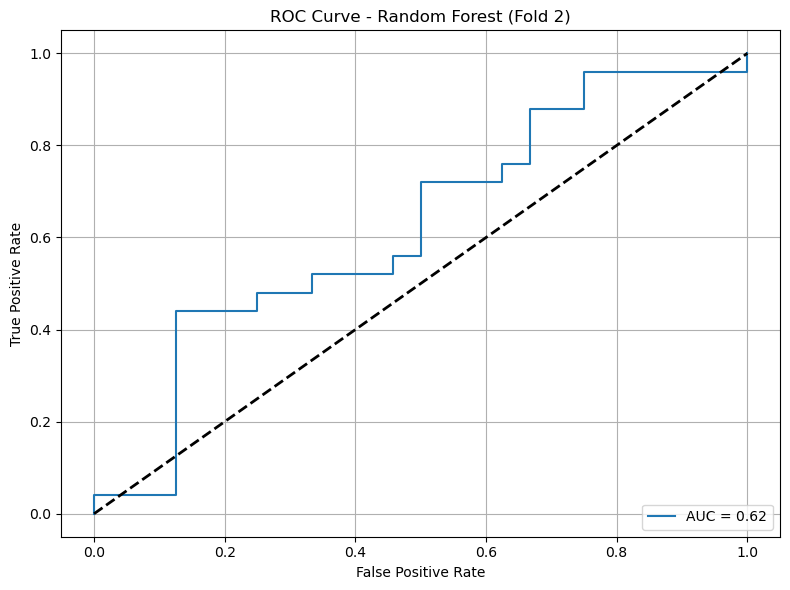

Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Fold 2 - KNN Score: 0.6205128205128204


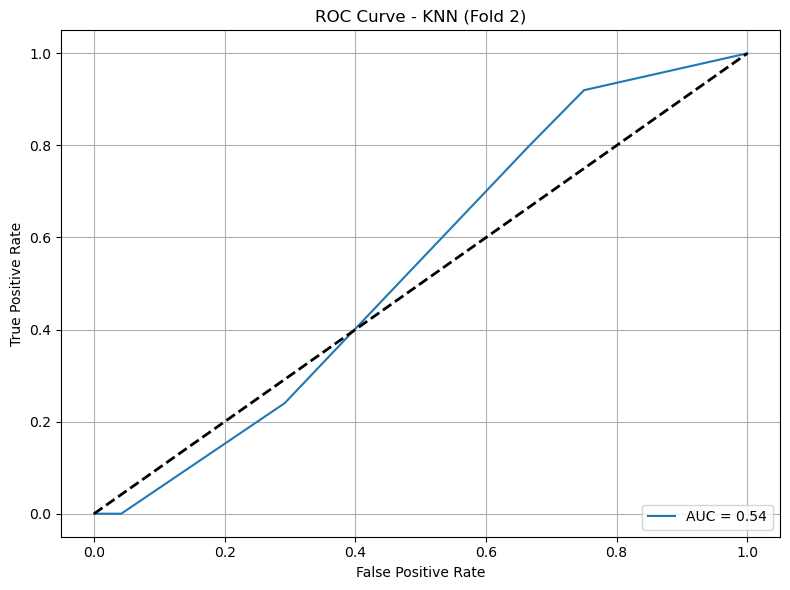

Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Fold 2 - SVM Score: 0.6398717948717949


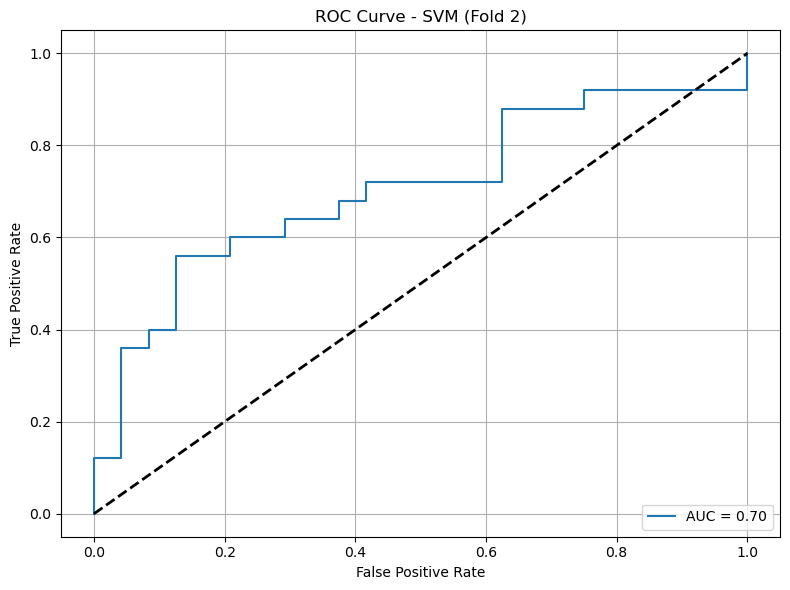


=== Fold 3 ===
(197, 462)
Start
7 features selected out of 10
Fold 3 - Logistic Regression Score: 0.6803846153846154


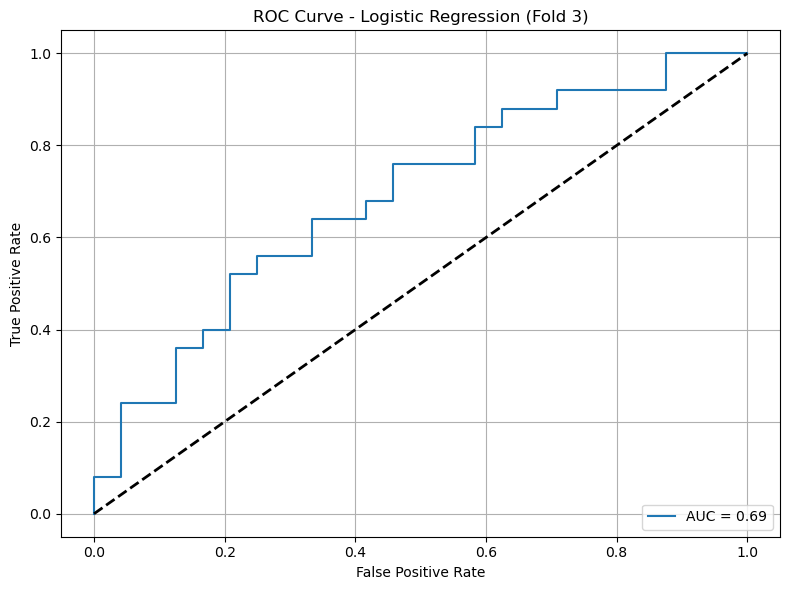

Best hyperparameters: {'max_depth': 23, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 62}
Fold 3 - Random Forest Score: 0.6856410256410257


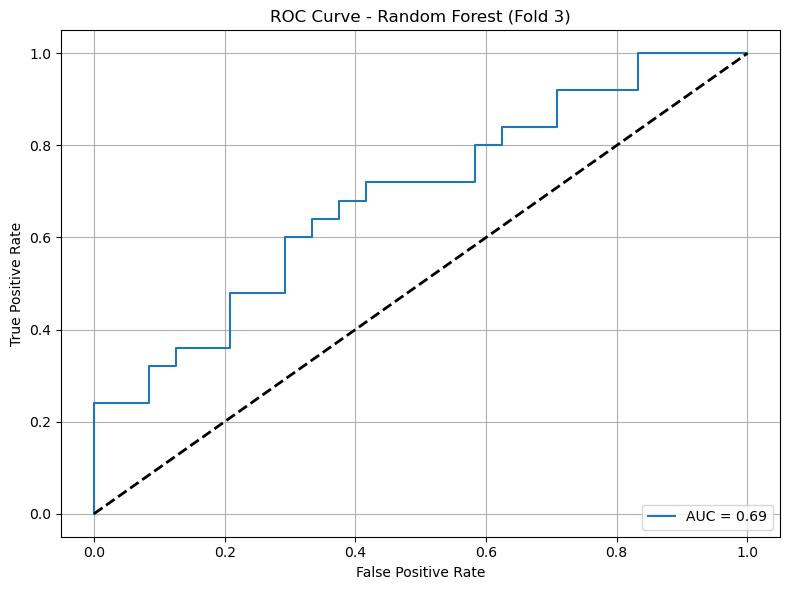

Best hyperparameters: {'n_neighbors': 25, 'weights': 'uniform'}
Fold 3 - KNN Score: 0.6598717948717949


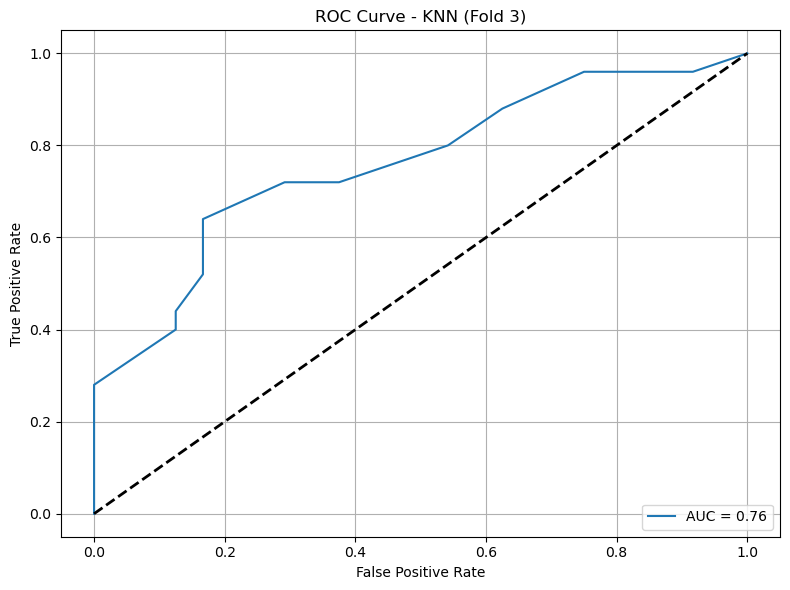

Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Fold 3 - SVM Score: 0.6655128205128206


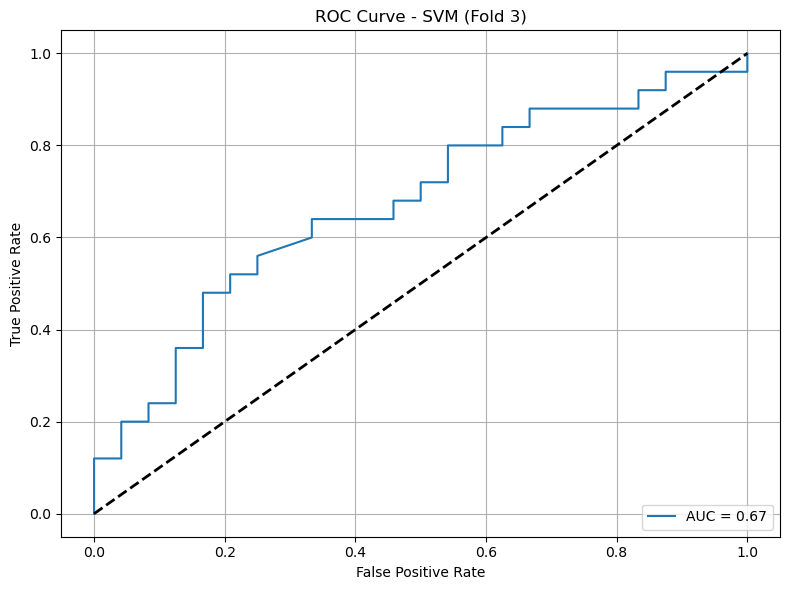


=== Fold 4 ===
(197, 460)
Start
9 features selected out of 10
Fold 4 - Logistic Regression Score: 0.6957692307692308


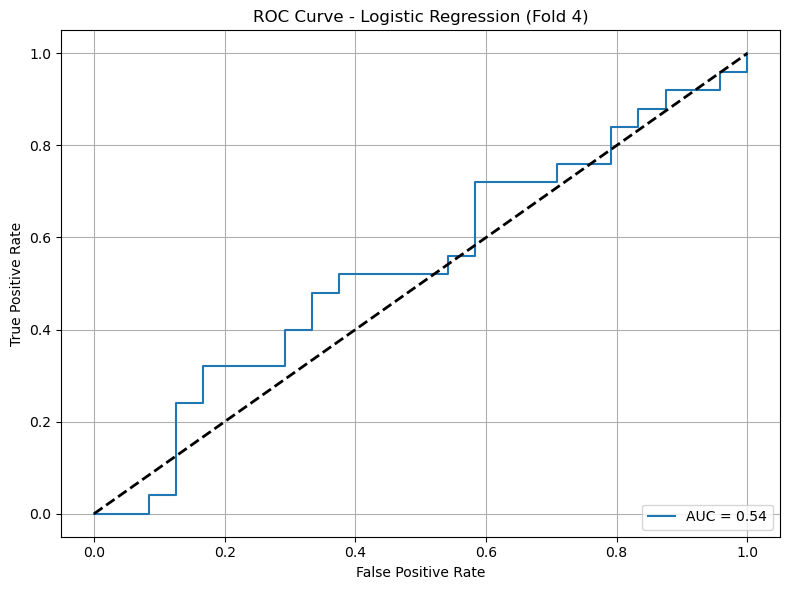

Best hyperparameters: {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 66}
Fold 4 - Random Forest Score: 0.7108974358974359


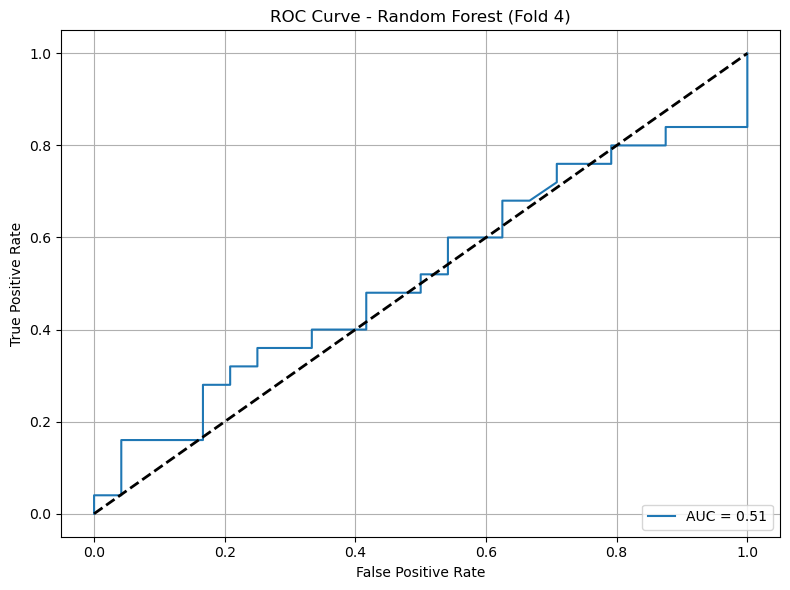

Best hyperparameters: {'n_neighbors': 17, 'weights': 'uniform'}
Fold 4 - KNN Score: 0.7006410256410256


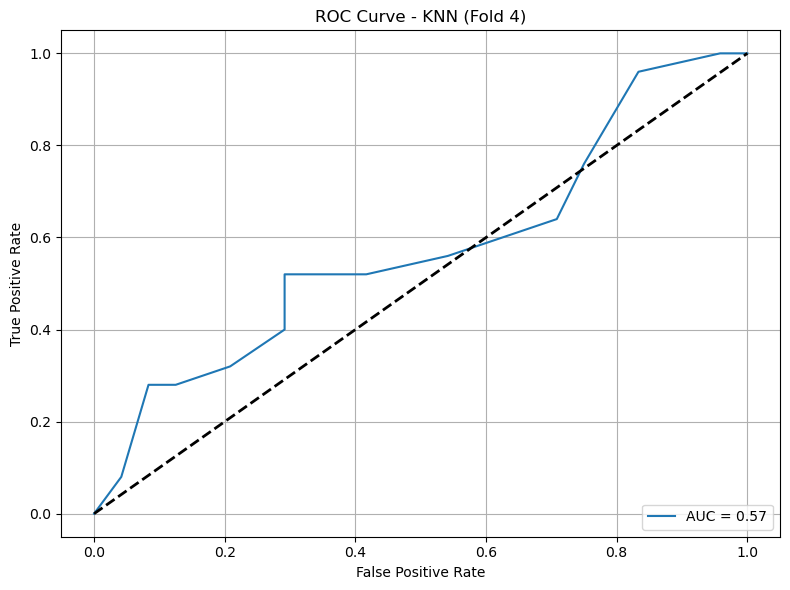

Best hyperparameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 4 - SVM Score: 0.726025641025641


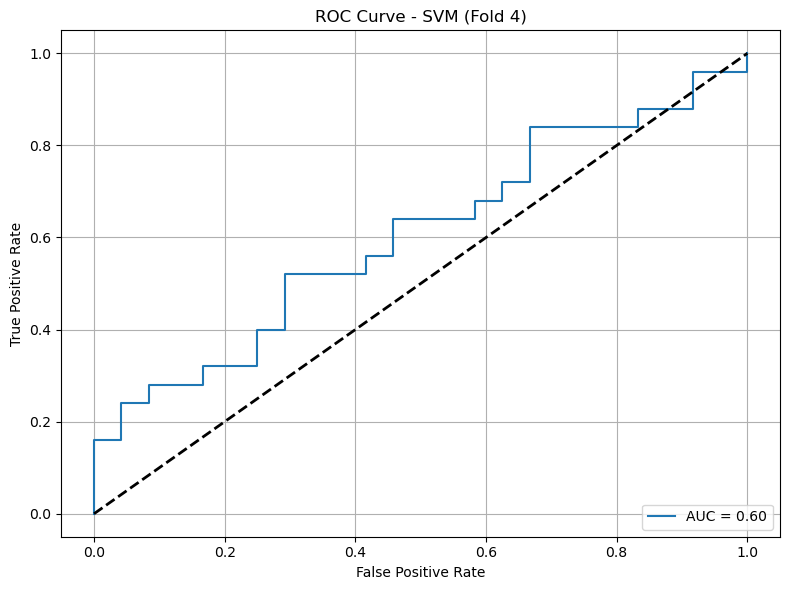

PermissionError: [Errno 13] Permission denied: 'cross_val_results.xlsx'

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
# Create a dataframe to store the results
cross_val_results = []
test_results = []

for fold, (train_index, test_index) in enumerate(skf.split(values, labels)):
    print(f"\n=== Fold {fold} ===")

    training_values = values.iloc[train_index]
    training_labels = labels[train_index]

    test_values = values.iloc[test_index]
    test_labels = labels[test_index]

    training_values, test_values = preprocess_train_test(training_values, test_values)

    #accuracies_logit = []
    #accuracies_forest = []
    #accuracies_knn = []
    #accuracies_SVM = []

    #for k in range(1, 50, 2):
    training_values_chosen, remaining_features = statistical_selection(training_values, training_labels, 10)
    ## Also remove those features from the test set
    test_values = test_values[remaining_features]

    print(training_values.shape)

    # Now train the classifiers

    logit_model, logit_score, selected_values = logistic_regression(training_values_chosen, training_labels)
    print(f"Fold {fold} - Logistic Regression Score: {logit_score['test_accuracy'].mean()}")
    #accuracies_logit.append(logit_score['test_accuracy'].mean())

    # Predict on the test data
    logit_test_predictions = logit_model.predict(test_values)
    logit_test_probabilities = logit_model.predict_proba(test_values)[:, 1]

    # Calculate metrics of test data
    test_results.append({'Model': logit_model, 'Fold': fold, 'Precision':  precision_score(test_labels, logit_test_predictions), 'Recall': recall_score(test_labels, logit_test_predictions),
                         'Accuracy': accuracy_score(test_labels, logit_test_predictions), 'ROC AUC': roc_auc_score(test_labels, logit_test_probabilities)})

    plot_best_model_roc(logit_test_probabilities, test_labels, 'Logistic Regression', fold)

    forest_model, forest_score = train_random_forest(training_values_chosen, training_labels)
    print(f"Fold {fold} - Random Forest Score: {forest_score['test_accuracy'].mean()}")
    #accuracies_forest.append(forest_score['test_accuracy'].mean())

    # Predict on the test data
    forest_test_predictions = forest_model.predict(test_values)
    forest_test_probabilities = forest_model.predict_proba(test_values)[:, 1]

    # Calculate metrics of test data
    test_results.append({'Model': forest_model, 'Fold': fold, 'Precision':  precision_score(test_labels, forest_test_predictions), 'Recall': recall_score(test_labels, forest_test_predictions),
                        'Accuracy': accuracy_score(test_labels, forest_test_predictions), 'ROC AUC': roc_auc_score(test_labels, forest_test_probabilities)})
    
    plot_best_model_roc(forest_test_probabilities, test_labels, 'Random Forest', fold)

    KNN_model, knn_score = KNN(training_values_chosen, training_labels)
    print(f"Fold {fold} - KNN Score: {knn_score['test_accuracy'].mean()}")
    #accuracies_knn.append(knn_score['test_accuracy'].mean())

    # Predict on the test data
    knn_test_predictions = KNN_model.predict(test_values)
    knn_test_probabilities = KNN_model.predict_proba(test_values)[:, 1]

    # Calculate metrics of test data
    test_results.append({'Model': KNN_model, 'Fold': fold, 'Precision':  precision_score(test_labels, knn_test_predictions), 'Recall': recall_score(test_labels, knn_test_predictions),
                        'Accuracy': accuracy_score(test_labels, knn_test_predictions), 'ROC AUC': roc_auc_score(test_labels, knn_test_probabilities)})
    
    plot_best_model_roc(knn_test_probabilities, test_labels, 'KNN', fold)

    SVM_model, svm_score = SVM(training_values_chosen, training_labels)
    print(f"Fold {fold} - SVM Score: {svm_score['test_accuracy'].mean()}")
    #accuracies_SVM.append(svm_score['test_accuracy'].mean())

    # Predict on the test data
    svm_test_predictions = SVM_model.predict(test_values)
    svm_test_probabilities = SVM_model.predict_proba(test_values)[:, 1]

    # Calculate metrics of test data
    test_results.append({'Model': SVM_model, 'Fold': fold, 'Precision':  precision_score(test_labels, svm_test_predictions), 'Recall': recall_score(test_labels, svm_test_predictions),
                        'Accuracy': accuracy_score(test_labels, svm_test_predictions), 'ROC AUC': roc_auc_score(test_labels, svm_test_probabilities)})
    
    plot_best_model_roc(svm_test_probabilities, test_labels, 'SVM', fold)

    """
    # Plot the accuracies for different classifiers as a function of k
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, 50, 2), accuracies_logit, label='Logistic Regression', marker='o')
    plt.plot(range(1, 50, 2), accuracies_forest, label='Random Forest', marker='s')
    plt.plot(range(1, 50, 2), accuracies_knn, label='KNN', marker='^')
    plt.plot(range(1, 50, 2), accuracies_SVM, label='SVM', marker='x')

    plt.xlabel('k (Number of Features Selected)')
    plt.ylabel('Accuracy')
    plt.title('Classifier Accuracies as a Function of k')
    plt.legend()
    plt.grid(True)
    plt.show()
    """

    # Append scores for each model
    cross_val_results.append({'Model': logit_model, 'Fold': fold, 'Precision': logit_score['test_precision'].mean(), 'Recall': logit_score['test_recall'].mean(), 'Accuracy': logit_score['test_accuracy'].mean(), 'ROC AUC': logit_score['test_roc_auc'].mean()})
    cross_val_results.append({'Model': forest_model, 'Fold': fold, 'Precision': forest_score['test_precision'].mean(), 'Recall': forest_score['test_recall'].mean(), 'Accuracy': forest_score['test_accuracy'].mean(), 'ROC AUC': forest_score['test_roc_auc'].mean()})
    cross_val_results.append({'Model': KNN_model, 'Fold': fold, 'Precision': knn_score['test_precision'].mean(), 'Recall': knn_score['test_recall'].mean(), 'Accuracy': knn_score['test_accuracy'].mean(), 'ROC AUC': knn_score['test_roc_auc'].mean()})
    cross_val_results.append({'Model': SVM_model, 'Fold': fold, 'Precision': svm_score['test_precision'].mean(), 'Recall': svm_score['test_recall'].mean(), 'Accuracy': svm_score['test_accuracy'].mean(), 'ROC AUC': svm_score['test_roc_auc'].mean()})


# Convert the results list to a dataframe
results_df = pd.DataFrame(cross_val_results)
results_test_df = pd.DataFrame(test_results)

results_df.to_excel('cross_val_results.xlsx', index=False)
results_test_df.to_excel('test_results.xlsx', index=False)

print(results_df)

